In [1]:
using PyPlot
using JLD2

include("../src/histogram_merging.jl")

fit_histogram_merging (generic function with 1 method)

In [2]:
function exactdp(ys::Array{Float64, 1}, k::Int)
    return fit_histogram_dp(ys, k)
end

function merging_k(ys::Array{Float64, 1}, k::Int)
    return fit_histogram_merging(ys, sigma, k, floor(Int, k / 2.0), initial_merging_size=1)
end

function merging_2k(ys::Array{Float64, 1}, k::Int)
    return fit_histogram_merging(ys, sigma, 2 * k, k, initial_merging_size=1)
end

function merging_4k(ys::Array{Float64, 1}, k::Int)
    return fit_histogram_merging(ys, sigma, 4 * k, 2 * k, initial_merging_size=1)
end

algos = Dict([("exactdp", exactdp), ("merging_k", merging_k), ("merging_2k", merging_2k), ("merging_4k", merging_4k)])

Dict{String, Function} with 4 entries:
  "exactdp"    => exactdp
  "merging_2k" => merging_2k
  "merging_4k" => merging_4k
  "merging_k"  => merging_k

In [3]:
num_data_sets = 10
num_trials = 10
sigma = 1.0
n_vals = round.(Int, 10 .^ range(2.0, stop=4.0, length=7))
k = 10
mses = Dict{String, Array{Float64, 2}}()
times = Dict{String, Array{Float64, 2}}()

for algo_name in keys(algos)
    mses[algo_name] = Array{Float64}(undef, length(n_vals), num_trials * num_data_sets)
    times[algo_name] = Array{Float64}(undef, length(n_vals), num_trials * num_data_sets)
end

# Warm-up for pre-compilation
n_warmup = 1000
bin_values = rand(1:10, k);
y, ystar = generate_equal_size_histogram_data(bin_values, n_warmup, sigma)
@printf("Warm-up with n = %d\n", n_warmup)
for (algo_name, algo_fun) in algos
    yhat_partition = algo_fun(y, k)
end

for (nii, n) in enumerate(n_vals)
    @printf("n = %d  ", n)
    
    @time begin
    for iidata = 1:num_data_sets
        bin_values = rand(1:10, k);
        @printf(".")
        
        for ii = 1:num_trials
            #@printf("  trial %d\n", ii)
            y, ystar = generate_equal_size_histogram_data(bin_values, n, sigma)

            for (algo_name, algo_fun) in algos
                #@printf("    algorithm %s\n", algo_name)
                start_time = time_ns()
                yhat_partition = algo_fun(y, k)
                end_time = time_ns()
                yhat = partition_to_vector(yhat_partition)
                mses[algo_name][nii, (iidata - 1) * num_trials + ii] = mse(yhat, ystar)
                times[algo_name][nii, (iidata - 1) * num_trials + ii] = 1e-9 * (end_time - start_time)
            end
        end
    end
    end
end

mses_mean = Dict{AbstractString, Array{Float64, 1}}()
mses_std = Dict{AbstractString, Array{Float64, 1}}()
times_mean = Dict{AbstractString, Array{Float64, 1}}()
times_std = Dict{AbstractString, Array{Float64, 1}}()
for algo_name in keys(mses)
    mses_mean[algo_name] = vec(mean(mses[algo_name], dims=2))
    mses_std[algo_name] = vec(std(mses[algo_name], dims=2))
    times_mean[algo_name] = vec(mean(times[algo_name], dims=2))
    times_std[algo_name] = vec(std(times[algo_name], dims=2))
end

Warm-up with n = 1000
n = 100  ..........  0.156920 seconds (399.19 k allocations: 42.434 MiB, 4.28% gc time, 79.67% compilation time)
n = 215  ..........  0.082391 seconds (338.13 k allocations: 57.047 MiB, 6.22% gc time)
n = 464  ..........  0.289608 seconds (654.77 k allocations: 116.206 MiB, 2.87% gc time)
n = 1000  ..........  1.163903 seconds (1.31 M allocations: 241.456 MiB, 0.86% gc time)
n = 2154  ..........  5.012874 seconds (2.73 M allocations: 541.375 MiB, 0.56% gc time)
n = 4642  .......... 21.968755 seconds (5.73 M allocations: 1.174 GiB, 0.32% gc time)
n = 10000  ..........101.038547 seconds (12.18 M allocations: 2.661 GiB, 0.16% gc time)


In [4]:
algo_colors = Dict([("exactdp", "blue"), ("merging_2k", "green"), ("merging_4k", "red"), ("merging_k", "olive")])

Dict{String, String} with 4 entries:
  "exactdp"    => "blue"
  "merging_2k" => "green"
  "merging_4k" => "red"
  "merging_k"  => "olive"

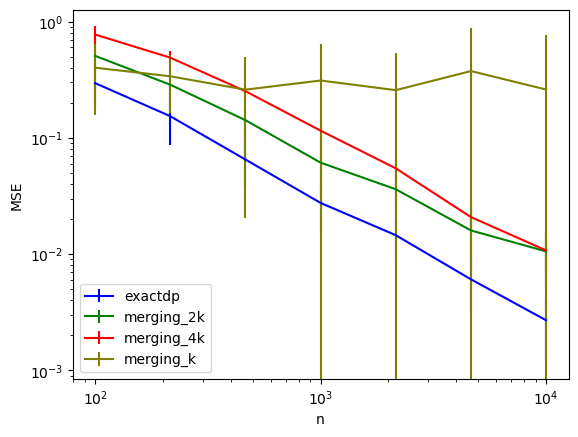

PyObject Text(24.000000000000007, 0.5, 'MSE')

In [5]:
for (algo_name, algo_mses) in mses_mean
    errorbar(n_vals, algo_mses, yerr=mses_std[algo_name], label=algo_name, color=algo_colors[algo_name])
end
#plot(n_vals, 200.0 ./ n_vals, label="C/n")
#plot(n_vals, 5.0 ./ sqrt(n_vals), label="C/sqrt(n)", color="olive")
legend()
yscale("log")
xscale("log")
xlabel("n")
ylabel("MSE")

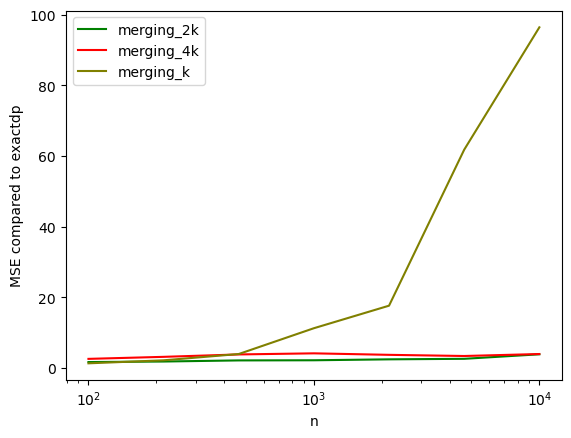

PyObject Text(24.000000000000007, 0.5, 'MSE compared to exactdp')

In [6]:
exactdp_mses = mses_mean["exactdp"]
for (algo_name, algo_mses) in mses_mean
    if algo_name != "exactdp"
        plot(n_vals, algo_mses ./ exactdp_mses, label=algo_name, color=algo_colors[algo_name])
    end
end
legend()
xscale("log")
xlabel("n")
ylabel("MSE compared to exactdp")

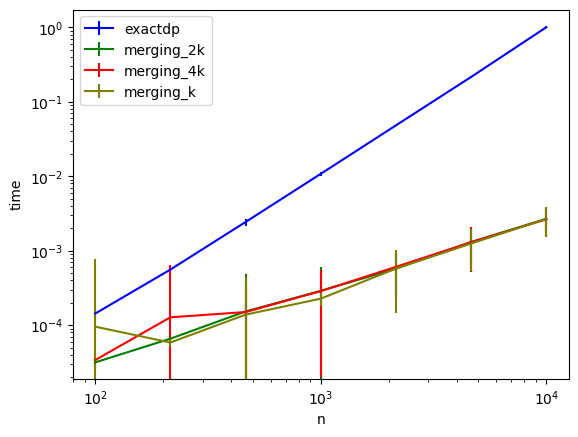

PyObject Text(24.000000000000007, 0.5, 'time')

In [7]:
for (algo_name, algo_times) in times_mean
    errorbar(n_vals, algo_times, yerr=times_std[algo_name], label=algo_name, color=algo_colors[algo_name])
end
legend()
yscale("log")
xscale("log")
xlabel("n")
ylabel("time")

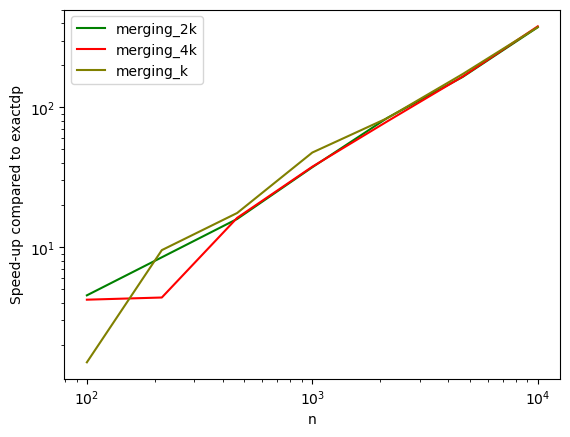

PyObject Text(24.000000000000007, 0.5, 'Speed-up compared to exactdp')

In [8]:
exactdp_times = times_mean["exactdp"]
for (algo_name, algo_times) in times_mean
    if algo_name != "exactdp"
        plot(n_vals, exactdp_times ./ algo_times, label=algo_name, color=algo_colors[algo_name])
    end
end
legend()
yscale("log")
xscale("log")
xlabel("n")
ylabel("Speed-up compared to exactdp")

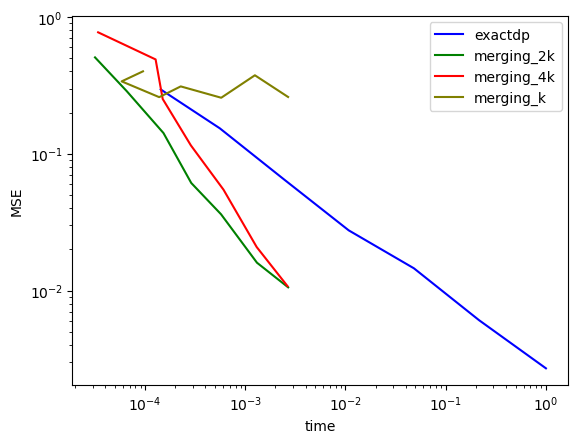

PyObject Text(24.000000000000007, 0.5, 'MSE')

In [9]:
for (algo_name, algo_times) in times_mean
    plot(algo_times, mses_mean[algo_name], label=algo_name, color=algo_colors[algo_name])
end
legend()
yscale("log")
xscale("log")
xlabel("time")
ylabel("MSE")

In [10]:
extra_algos = Dict([("merging_k", merging_k), ("merging_2k", merging_2k), ("merging_4k", merging_4k)])
extra_n_vals = round.(Int, 10 .^ range(4.0, stop=6.0, length=7))
extra_mses = Dict{String, Array{Float64, 2}}()
extra_times = Dict{String, Array{Float64, 2}}()

for algo_name in keys(extra_algos)
    extra_mses[algo_name] = Array{Float64}(undef, length(extra_n_vals), num_trials * num_data_sets)
    extra_times[algo_name] = Array{Float64}(undef, length(extra_n_vals), num_trials * num_data_sets)
end

# Warm-up for pre-compilation
n_warmup = 1000
bin_values = rand(1:10, k);
y, ystar = generate_equal_size_histogram_data(bin_values, n_warmup, sigma)
@printf("Warm-up with n = %d\n", n_warmup)
for (algo_name, algo_fun) in extra_algos
    yhat_partition = algo_fun(y, k)
end

for (nii, n) in enumerate(extra_n_vals)
    @printf("n = %d  ", n)
    @time begin
    for iidata = 1:num_data_sets
        bin_values = rand(1:10, k);
        @printf(".")
        
        for ii = 1:num_trials
            #@printf("  trial %d\n", ii)
            y, ystar = generate_equal_size_histogram_data(bin_values, n, sigma)

            for (algo_name, algo_fun) in extra_algos
                #@printf("    algorithm %s\n", algo_name)
                start_time = time_ns()
                yhat_partition = algo_fun(y, k)
                end_time = time_ns()
                yhat = partition_to_vector(yhat_partition)
                extra_mses[algo_name][nii, (iidata - 1) * num_trials + ii] = mse(yhat, ystar)
                extra_times[algo_name][nii, (iidata - 1) * num_trials + ii] = 1e-9 * (end_time - start_time)
            end
        end
    end
    end
end

extra_mses_mean = Dict{AbstractString, Array{Float64, 1}}()
extra_mses_std = Dict{AbstractString, Array{Float64, 1}}()
extra_times_mean = Dict{AbstractString, Array{Float64, 1}}()
extra_times_std = Dict{AbstractString, Array{Float64, 1}}()
for algo_name in keys(extra_mses)
    extra_mses_mean[algo_name] = vec(mean(extra_mses[algo_name], dims=2))
    extra_mses_std[algo_name] = vec(std(extra_mses[algo_name], dims=2))
    extra_times_mean[algo_name] = vec(mean(extra_times[algo_name], dims=2))
    extra_times_std[algo_name] = vec(std(extra_times[algo_name], dims=2))
end

Warm-up with n = 1000
n = 10000  ..........  0.811829 seconds (12.18 M allocations: 2.476 GiB, 18.59% gc time, 0.27% compilation time)
n = 21544  ..........  1.735789 seconds (26.07 M allocations: 5.314 GiB, 18.32% gc time)
n = 46416  ..........  4.417447 seconds (55.95 M allocations: 11.255 GiB, 30.26% gc time)
n = 100000  ..........  9.961296 seconds (120.31 M allocations: 24.184 GiB, 31.79% gc time)
n = 215443  .......... 25.879698 seconds (258.94 M allocations: 53.128 GiB, 41.67% gc time)
n = 464159  .......... 63.353250 seconds (557.54 M allocations: 112.786 GiB, 47.37% gc time)
n = 1000000  ..........116.730785 seconds (1.20 G allocations: 243.158 GiB, 36.78% gc time)


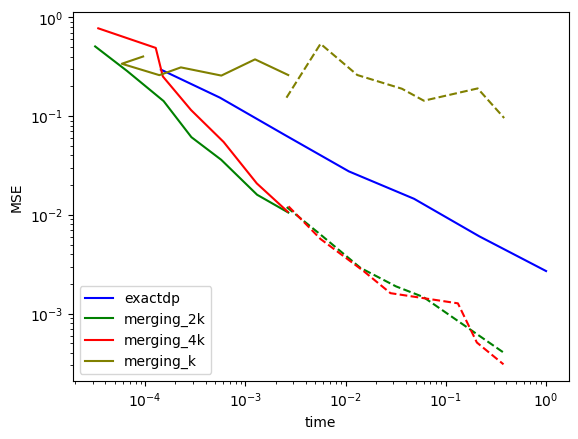

PyObject Text(24.000000000000007, 0.5, 'MSE')

In [11]:
for (algo_name, algo_times) in times_mean
    plot(algo_times, mses_mean[algo_name], label=algo_name, color=algo_colors[algo_name])
end
for (algo_name, algo_times) in extra_times_mean
    plot(algo_times, extra_mses_mean[algo_name], color=algo_colors[algo_name], linestyle="--")
end
legend()
yscale("log")
xscale("log")
xlabel("time")
ylabel("MSE")

In [12]:
mses_std

Dict{AbstractString, Vector{Float64}} with 4 entries:
  "exactdp"    => [0.110529, 0.0666503, 0.0271012, 0.0120174, 0.00588237, 0.002…
  "merging_2k" => [0.132969, 0.0673454, 0.0455128, 0.0240522, 0.0139086, 0.0081…
  "merging_4k" => [0.136759, 0.071853, 0.044866, 0.025808, 0.0125263, 0.0068254…
  "merging_k"  => [0.244991, 0.174669, 0.23935, 0.325271, 0.27689, 0.504167, 0.…

In [13]:
times["merging_2k"]

7×100 Matrix{Float64}:
 3.7044e-5    3.1553e-5    2.7933e-5    …  3.2967e-5    3.3614e-5
 6.242e-5     5.8751e-5    5.7484e-5       7.5681e-5    6.6991e-5
 0.000115581  0.000111949  0.000109988     0.000170945  0.000114967
 0.000218408  0.000219935  0.000230972     0.000227911  0.000251397
 0.000917851  0.000470427  0.00058728      0.000469415  0.000447471
 0.00111655   0.00101835   0.0011843    …  0.000976036  0.00102958
 0.0026002    0.00219534   0.00485403      0.0021987    0.00230577

In [14]:
times_std["merging_2k"]

7-element Vector{Float64}:
 5.060669229070459e-6
 6.342246312059182e-6
 0.0003360688970905667
 0.00032099337088864656
 0.00033679562898374375
 0.0007511785776100516
 0.0010830443596305838

In [15]:
@save "experiments2_k10.jld2"

In [16]:
include("../src/helpers.jl")

write_experiment_data_with_ratios (generic function with 1 method)

In [17]:
write_experiment_data("constant", "exactdp", n_vals, mses_mean, mses_std, times_mean, times_std)

In [18]:
for algo_name in keys(algos)
    write_experiment_data_with_ratios("experiments2_k10", algo_name, "exactdp", n_vals, mses_mean, mses_std, times_mean, times_std)
end

In [19]:
for algo_name in keys(extra_algos)
    write_experiment_data("experiments2_k10_extra", algo_name, extra_n_vals, extra_mses_mean, extra_mses_std, extra_times_mean, extra_times_std)
end